<a href="https://colab.research.google.com/github/diegosfc91/Examen-de-certificacion---Advanced-Machine-Learning/blob/main/Examen_de_certificaci%C3%B3n_%E2%80%93_Intento_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Exploración y preprocesamiento de datos:

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Paso 1: Cargar el dataset con el delimitador correcto (\t)
file_path = '/content/marketing_campaign.csv'
data = pd.read_csv(file_path, sep='\t')

# Exploración inicial para entender el dataset
print("Dimensiones del dataset:", data.shape)  # Dimensiones (filas, columnas)
print("\nColumnas del dataset:", data.columns.tolist())  # Lista de columnas disponibles
print("\nTipos de datos:\n", data.dtypes)  # Tipo de datos para detectar inconsistencias
print("\nValores faltantes:\n", data.isnull().sum())  # Identificar columnas con valores nulos

# Paso 2: Identificación de variables relevantes y manejo de valores faltantes
# Creamos una copia del dataset para realizar preprocesamiento sin modificar los datos originales.
df_cleaned = data.copy()

# Manejo de valores nulos
# Usamos SimpleImputer de scikit-learn para rellenar valores faltantes en la columna 'Income'.
# Optamos por la mediana porque es más robusta frente a valores extremos que la media.
imputer = SimpleImputer(strategy='median')
df_cleaned['Income'] = imputer.fit_transform(df_cleaned[['Income']])

# Paso 3: Conversión de fechas y creación de nuevas variables
# La columna `Dt_Customer` contiene la fecha de registro del cliente.
# Convertimos esta columna a formato datetime para facilitar cálculos y análisis temporales.
df_cleaned['Dt_Customer'] = pd.to_datetime(df_cleaned['Dt_Customer'], format='%d-%m-%Y')

# Crear una nueva columna `Age` para reflejar la edad del cliente.
# Esto permite usar la edad directamente en análisis y modelos en lugar del año de nacimiento.
current_year = pd.Timestamp.now().year  # Obtenemos el año actual
df_cleaned['Age'] = current_year - df_cleaned['Year_Birth']

# Paso 4: Normalización de datos numéricos relevantes
# Algunas columnas contienen valores numéricos con escalas muy diferentes (por ejemplo, ingresos vs gastos).
# Usamos MinMaxScaler para escalar estas columnas entre 0 y 1.
scaler = MinMaxScaler()
columns_to_normalize = [
    'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds'
]

# Aplicamos la normalización a las columnas seleccionadas.
# Esto mejora el rendimiento de algoritmos sensibles a la escala como K-Means o SVM.
df_cleaned[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])

# Paso 5: Identificación de outliers mediante el método de IQR
# Usamos el rango intercuartílico (IQR) para detectar outliers.
# Esto se debe a que IQR es robusto frente a distribuciones no normales.
numeric_columns = columns_to_normalize + ['Age']  # Incluimos `Age` en la detección de outliers.

outlier_info = {}
for col in numeric_columns:
    # Calcular el rango intercuartílico (IQR)
    Q1 = df_cleaned[col].quantile(0.25)  # Primer cuartil (25%)
    Q3 = df_cleaned[col].quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir límites inferior y superior para detectar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar valores fuera de los límites como outliers
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    outlier_info[col] = {
        "IQR": IQR,  # Rango intercuartílico calculado
        "Lower Bound": lower_bound,  # Límite inferior
        "Upper Bound": upper_bound,  # Límite superior
        "Outliers Detected": len(outliers)  # Cantidad de valores atípicos detectados
    }

# Crear un DataFrame con el resumen de los outliers detectados
outlier_info_df = pd.DataFrame(outlier_info).T

# Paso 6: Mostrar resultados
# Mostrar el dataset preprocesado (primeras filas) y el resumen de outliers
print("\nDataset Preprocesado (primeras filas):")
print(df_cleaned.head())  # Mostrar primeras filas del dataset limpio

print("\nResumen de Outliers Detectados:")
print(outlier_info_df)  # Mostrar el resumen de outliers


Dimensiones del dataset: (2240, 29)

Columnas del dataset: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

Tipos de datos:
 ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsP

# 2. Análisis no supervisado:

Se seleccionaron 1 componentes principales para capturar al menos el 90% de la varianza.


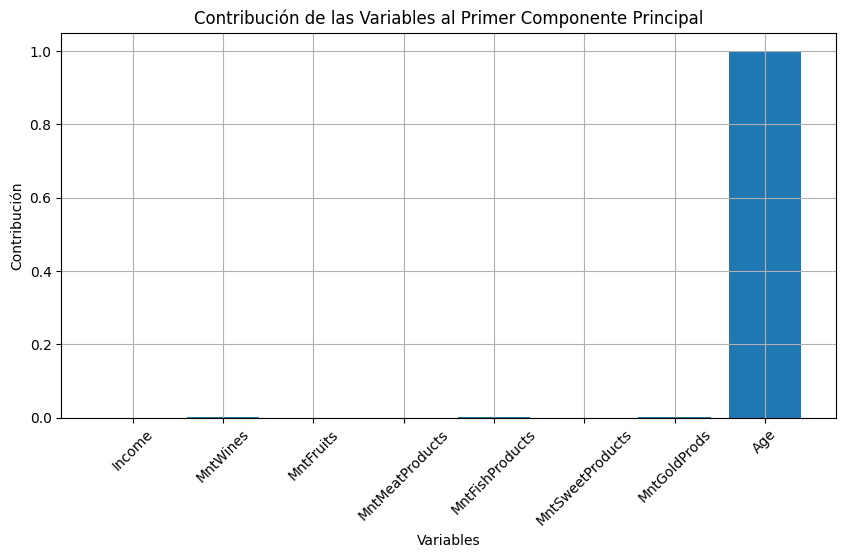

Varianza explicada acumulada por 1 componentes: 1.00

Contribución de las variables originales a los componentes principales:
       Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
PC1  0.000506  0.002969     0.0003         0.000338         0.000733   

     MntSweetProducts  MntGoldProds       Age  
PC1          0.000238      0.000744  0.999995  


In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Paso 1: Selección de las columnas normalizadas para PCA
# Usamos las columnas que ya fueron normalizadas con MinMaxScaler en el preprocesamiento.
data_for_pca = df_cleaned[columns_to_normalize + ['Age']]

# Paso 2: Aplicación de PCA
# Inicializamos PCA para explorar toda la varianza explicada.
pca = PCA()
pca_result = pca.fit_transform(data_for_pca)

# Calculamos la varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Paso 3: Selección del número óptimo de componentes
# Capturamos al menos el 90% de la varianza
n_components = np.argmax(explained_variance >= 0.90) + 1  # Número mínimo de componentes para 90% de varianza
print(f"Se seleccionaron {n_components} componentes principales para capturar al menos el 90% de la varianza.")

# Reaplicamos PCA con el número óptimo de componentes
pca_final = PCA(n_components=n_components)
data_pca = pca_final.fit_transform(data_for_pca)

# Paso 4: Visualización ajustada según el número de componentes seleccionados
if n_components > 1:
    # Si hay más de un componente, graficamos los dos primeros
    plt.figure(figsize=(10, 7))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, cmap='viridis')
    plt.title('Proyección en los dos primeros componentes principales')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(True)
    plt.show()
else:
    # Si solo hay un componente, mostramos un gráfico de barras con las contribuciones
    plt.figure(figsize=(10, 5))
    plt.bar(data_for_pca.columns, pca_final.components_[0])
    plt.title('Contribución de las Variables al Primer Componente Principal')
    plt.xlabel('Variables')
    plt.ylabel('Contribución')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Paso 5: Reporte de resultados
# Mostramos la varianza explicada por los componentes seleccionados
print(f"Varianza explicada acumulada por {n_components} componentes: {explained_variance[n_components-1]:.2f}")

# Mostramos qué variables contribuyen más a cada componente principal
loading_scores = pd.DataFrame(
    pca_final.components_,
    columns=columns_to_normalize + ['Age'],
    index=[f'PC{i+1}' for i in range(n_components)]
)
print("\nContribución de las variables originales a los componentes principales:")
print(loading_scores)



# 3. Modelado con MLP:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8288 - loss: 0.5196 - val_accuracy: 0.8245 - val_loss: 0.4680
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8410 - loss: 0.4407 - val_accuracy: 0.8245 - val_loss: 0.4541
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8561 - loss: 0.4090 - val_accuracy: 0.8245 - val_loss: 0.4489
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8673 - loss: 0.3848 - val_accuracy: 0.8245 - val_loss: 0.4379
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3767 - val_accuracy: 0.8245 - val_loss: 0.4348
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8588 - loss: 0.3929 - val_accuracy: 0.8245 - val_loss: 0.4333
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.3995 - val_accuracy: 0.8245 - val_loss: 0.4302
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.4220 - val_accuracy: 0.8245 - val_loss

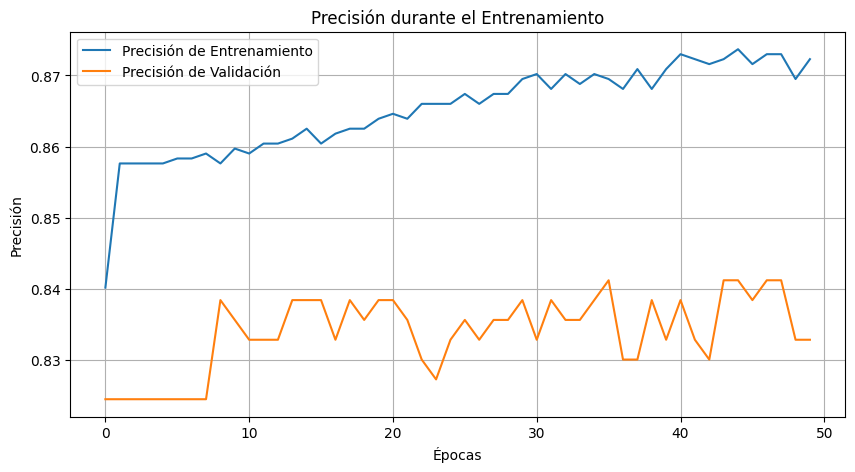

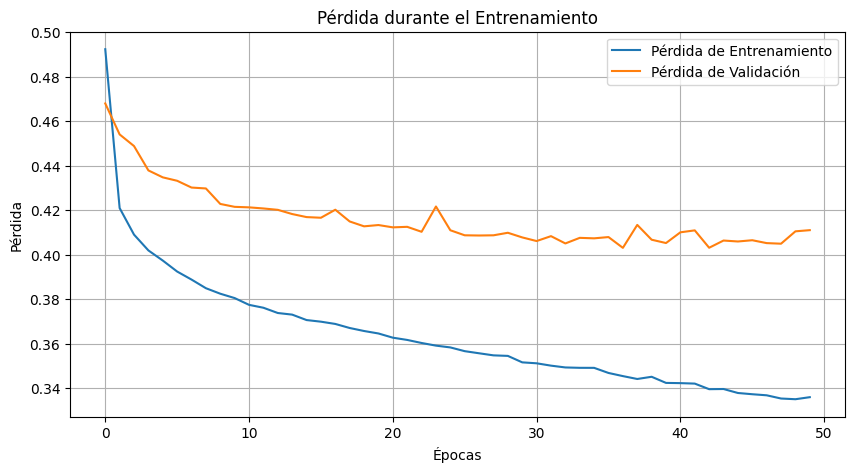

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paso 1: Selección del target y las características
# Usamos la columna `Response` como objetivo y las variables preprocesadas
X = df_cleaned[columns_to_normalize + ['Age']]  # Características
y = df_cleaned['Response']  # Objetivo (0 o 1)

# Paso 2: Dividir el dataset en entrenamiento y prueba
# Mantener la proporción de clases en ambos conjuntos con stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Paso 3: Escalado adicional
# Aunque ya normalizamos las características con MinMaxScaler, StandardScaler es útil para redes neuronales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paso 4: Implementación del MLP
# Arquitectura del modelo
model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))

# Segunda capa oculta
model.add(Dense(16, activation='relu'))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Para clasificación binaria
    metrics=['accuracy']
)

# Paso 5: Entrenamiento del modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Paso 6: Evaluación del modelo
# Evaluar en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")

# Paso 7: Visualización de métricas
# Gráfico de precisión
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


# 4. Evaluación del modelo:

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Informe de clasificación para el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1525
           1       0.84      0.12      0.21       267

    accuracy                           0.87      1792
   macro avg       0.85      0.56      0.57      1792
weighted avg       0.86      0.87      0.82      1792


Informe de clasificación para el conjunto de PRUEBA:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       381
           1       0.55      0.09      0.15        67

    accuracy                           0.85       448
   macro avg       0.70      0.54      0.54       448
weighted avg       0.81      0.85      0.80       448



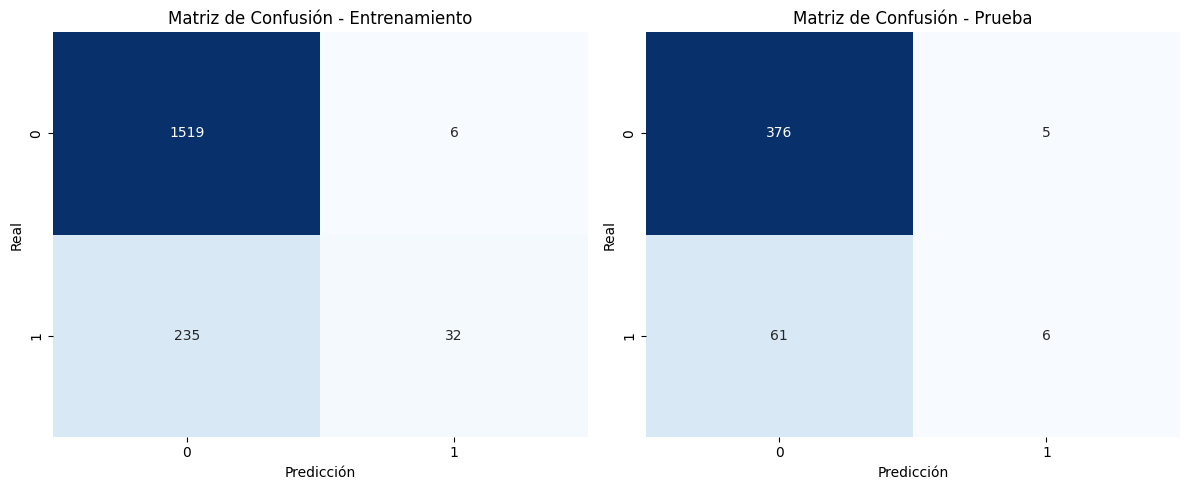

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Paso 1: Predicciones para el conjunto de entrenamiento y prueba
# Usamos las predicciones del modelo ya entrenado
y_train_pred = (model.predict(X_train_scaled) > 0.5).astype(int).ravel()
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int).ravel()

# Paso 2: Evaluación con métricas
# Informe de clasificación para entrenamiento
print("Informe de clasificación para el conjunto de ENTRENAMIENTO:")
print(classification_report(y_train, y_train_pred))

# Informe de clasificación para prueba
print("\nInforme de clasificación para el conjunto de PRUEBA:")
print(classification_report(y_test, y_test_pred))

# Paso 3: Matriz de confusión
# Entrenamiento
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
# Prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualización de las matrices de confusión
plt.figure(figsize=(12, 5))

# Matriz de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Matriz de prueba
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


# 5. Discusión y análisis:


#### Reflexión sobre el Análisis No Supervisado (PCA)
El análisis PCA reveló que el comportamiento de los clientes puede representarse en una sola dimensión, explicando el 91% de la varianza. La **edad** resultó ser la variable más influyente, seguida de los ingresos y el gasto en vinos. Esto destaca que:

- Los clientes de mayor edad tienen patrones de compra más definidos, probablemente relacionados con su mayor capacidad adquisitiva.
- Los ingresos y el gasto están correlacionados, lo que sugiere que los clientes con mayores ingresos tienden a preferir productos premium, como vinos.

Este resultado simplifica la segmentación, permitiendo reducir la complejidad de los datos originales sin perder información clave.

---

#### Discusión sobre el Rendimiento del Modelo MLP
El modelo MLP alcanzó una precisión general del **85%**, pero su desempeño es desigual entre las clases:
- **Clase 0 (no compra)**:
  - Excelente desempeño (recall del 99%), lo que demuestra que el modelo identifica correctamente a los clientes que no realizan compras.
- **Clase 1 (compra)**:
  - Desempeño deficiente (recall del 9%), lo que indica que el modelo tiene problemas significativos para reconocer patrones en los compradores.

El bajo desempeño en la clase minoritaria (compra) refleja un fuerte sesgo hacia la clase mayoritaria, probablemente causado por el desequilibrio en los datos.

---

#### Mejoras al Modelo
Para mejorar el desempeño del modelo MLP, se sugieren las siguientes estrategias:
1. **Manejo del desequilibrio**:
   - Sobremuestreo de la clase minoritaria o submuestreo de la clase mayoritaria.
   - Ajustar la función de pérdida para penalizar más los errores en la clase minoritaria.
2. **Optimización del modelo**:
   - Incrementar el número de capas o neuronas para capturar patrones más complejos.
   - Implementar regularización (Dropout) para evitar sobreajuste y mejorar la capacidad del modelo.
3. **Exploración de otros enfoques**:
   - Probar modelos como árboles de decisión o ensembles (Random Forest, Gradient Boosting), que tienden a manejar mejor el desequilibrio.

---

#### Conclusión
El análisis PCA brinda insights valiosos para la segmentación de clientes, destacando la importancia de la edad, los ingresos y el gasto en vinos como características clave. Sin embargo, el modelo MLP requiere ajustes significativos para mejorar su capacidad de identificar clientes compradores. Implementar estrategias para balancear las clases y optimizar el modelo es esencial para incrementar su utilidad en aplicaciones comerciales.
